## Compare Classifier Predictions using Reliability Diagrams

Reliability diagrams allow checking if the predicted probabilities of a binary classifier are well calibrated. 

For perfectly calibrated predictions, the curve in a reliability diagram should be as close as possible to the diagonal/identity. This would correspond to a situation in which among $N$ instances for which a classifier predicts probability $p$ for class $A$, the ratio of instances which actually belong to class $A$ is approx. $p$ (for any $p$ and sufficiently large $N$).

大数定律。

对于一个分类器，如果被分成 A 的概率为 0.8, 那么，当会 N 足够大时，应该用 80% 个样本被划分为 A。


In [41]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.isotonic import IsotonicRegression

np.random.seed(0)

In [42]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):
    """Compute reliability curve
    
    Reliability curves allow checking if the predicted probalities of a binary classifier are well calibrated. 
    This function returns two arrays which encode a mapping from predicted probability to empirical probability. 
    For this, the predicated probabilities are partitioned into equally sized bins and the mean predicted probabilities
    and the mean empirical probabilities in the bins are computed. For perfectly calibrated predictions, both quantities
    would be approximately equal(for sufficiency many test samples).
    
    Note: this implementation is restricted to binary classification.
    
    Parameters
    ----------
    
    y_true: array, shape = [n_samples]
        True binary labels (0 or 1).
        
    y_score: array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class or confidence values. If normalize
        is False, y_score must be in the interval [0, 1]. 预测的概率，如果不在 [0, 1] 之间，可以归一化。
    
    bins: int, optional, default = 10
        The number of bins into which the y_scores are partitioned.
        Note: n_samples should be considerably larger than bins such that there is sufficient data in each bin to get 
        a reliable estimate of the reliablity.
    
    normalize: bool, optional, default=False
        Whether y_score needs to be normalized into the bin [0, 1]. If true, the smallest value in y_score is mapped
        onto 0 and the largest one onto 1.
    
    Returns
    -------
    y_score_bin_mean: array, shape = [bins]
        The mean predicted y_score in the respective bins.
    
    empirical_prob_pos: array, shape = [bins]
        The empirical probability (frequency) of the positive class (+1) in the repective bins.
    """
    if normalize:
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2
    
    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width/2 < y_score, y_score <= threshold + bin_width/2)
        
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

### Training data

In [43]:
X, y = datasets.make_classification(n_samples=100000, n_features=20, n_informative=2, n_redundant=2)

bins = 25
train_samples = 100 # Samples used for training the models
calibration_samples = 400 # Additional samples for calibration using Isotonic Regression

X_train = X[:train_samples]
X_calibration = X[train_samples:train_samples+calibration_samples]
X_test = X[train_samples+calibration_samples:]
y_train = y[:train_samples]
y_calibration = y[train_samples:train_samples+calibration_samples]
y_test = y[train_samples+calibration_samples:]

### Compute reliability curves for different classifiers:

- Logistic Regression
- Naive Bayes
- Random Forest
- Support-Vector Classification(scores)
- Support-Vector + Isotonic Calibration

In [44]:
classifiers = {
    "Logistic regression": LogisticRegression(solver='lbfgs'),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
#     "SVC": SVC(kernel="linear", C=1.0),
#     "SVC + IR": SVC(kernel='linear', C=1.0)
}

reliability_scores = {}
y_score = {}

for method, clf in classifiers.items():
    clf.fit(X_train, y_train)
#     if method == "SVC + IR":
#         # Calibrate SVC scores using isotonic regression
#         n_plus = (y_calibration == 1.0).sum() # number of positive examples
#         n_minus = (y_calibration == 0.0).sum() # number of negative examples
#                 # Determine target values for isotonic calibration. See 
#         # "Predicting Good Probabilities with Supervised Learning"
#         # for details.
#         y_target = np.where(y_calibration == 0.0, 
#                             1.0 / (n_minus + 2.0),
#                             (n_plus + 1.0) / (n_plus + 2.0))
#         # Perform actual calibration using isotonic calibration
#         svm_score = clf.decision_function(X_calibration)[:, 0]
#         ir = IsotonicRegression(out_of_bounds='clip').fit(svm_score, y_target)
#         y_score[method] = ir.transform(clf.decision_function(X_test)[:, 0])
#         reliability_scores[method] = breliability_curve(y_test, y_score[method], bins=bins, normalize=False)
#     elif method == "SVC":
#         # Use SVC scores (predict_proba returns already calibrated probabilities)
#         y_score[method] = clf.decision_function(X_test)[:, 0]
#         reliability_scores[method] = reliability_curve(y_test, y_score[method], bins=bins, normalize=True)
#     else:
    y_score[method] = clf.predict_proba(X_test)[:,0]
    reliability_scores[method] = reliability_curve(y_test, y_score[method], bins=bins, normalize=False)
        

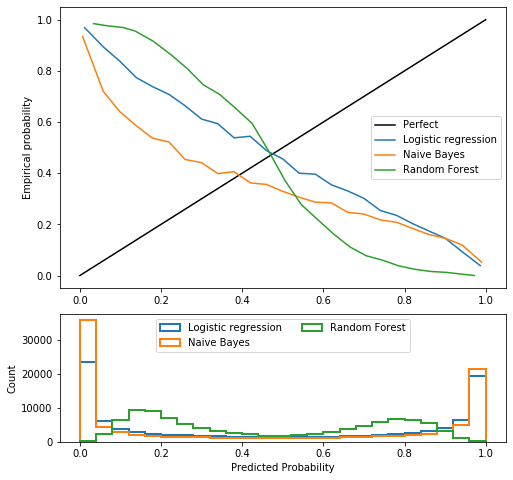

In [46]:
import matplotlib.pyplot as plt

plt.figure(0, figsize=(8, 8))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect")
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)
plt.show()

### References
1. [Compare Classifier Predictions using Reliability Diagrams](https://jmetzen.github.io/2014-08-16/reliability-diagram.html)
2. [Probability calibration](https://jmetzen.github.io/2015-04-14/calibration.html)